In [1]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import copy

from tslib.src import tsUtils
from tslib.src.synthcontrol.syntheticControl import RobustSyntheticControl
from tslib.src.synthcontrol.multisyntheticControl import MultiRobustSyntheticControl

import random
from numpy.linalg import svd, matrix_rank, norm
from sklearn import linear_model
import pickle

In [123]:
def hsvt(X, rank): 
    """
    Input:
        X: matrix of interest
        rank: rank of output matrix
    Output:
        thresholded matrix
    """
    u, s, v = np.linalg.svd(X, full_matrices=False)
    s[rank:].fill(0)
    return np.dot(u*s, v)

def hsvt_df(X, rank): 
    """
    Input:
        X: matrix of interest
        rank: rank of output matrix
    Output:
        thresholded matrix
    """
    u, s, v = np.linalg.svd(X, full_matrices=False)
    s[rank:].fill(0)
    vals = (np.dot(u*s, v))
    return pd.DataFrame(vals, index = X.index, columns = X.columns)

def matrixFromSVD(sk, Uk, Vk, probability=1.0):
    # Jehangir's
    return (1.0/probability) * np.dot(Uk, np.dot(np.diag(sk), Vk.T))

def hsvt_new(X, rank):
    Uk, sk, Vk = np.linalg.svd(X, full_matrices=False)
    Vk = Vk.T
    sk[rank:].fill(0)
    output = matrixFromSVD(sk, Uk, Vk, probability=1.0)
    return output

def hsvt_new_df(df, rank):
    Uk, sk, Vk = np.linalg.svd(df.values, full_matrices=False)
    Vk = Vk.T
    sk[rank:].fill(0)
    output = matrixFromSVD(sk, Uk, Vk, probability=1.0)
    return pd.DataFrame(output, index=df.index, columns=df.columns)

def get_preint_data(X, T0, T, K):
    """
    Input:
        X: N x KT matrix
        T0: pre-int period
        T: total period
        K: number of metrics
    
    Output:
        X_pre: N x KT0 matrix
    """
    X_pre = np.array([])
    for k in range(K): 
        if X.ndim > 1:
            X_temp = X[:, k*T:k*T + T0]
        else:
            X_temp = X[k*T:k*T + T0]
        X_pre = np.hstack([X_pre, X_temp]) if X_pre.size else X_temp
    return X_pre

def get_postint_data(X, T0, T, K):
    """
    Input:
        X: N x KT matrix
        T0: pre-int period
        T: total period
        K: number of metrics
    
    Output:
        X_post: N x K(T-T0) matrix
    """
    X_post = np.array([])
    for k in range(K): 
        if X.ndim > 1:
            X_temp = X[:, k*T+T0:(k+1)*T]
        else:
            X_temp = X[k*T+T0:(k+1)*T]
        X_post = np.hstack([X_post, X_temp]) if X_post.size else X_temp
    return X_post


def pre_post_split(y, T0, T, num_metrics):
        y_pre = get_preint_data(y, T0, T, num_metrics)
        y_post = get_postint_data(y, T0, T, num_metrics)
        return y_pre, y_post


def approximate_rank(X, t=99):
    """
    Input:
        X: matrix of interest
        t: an energy threshold. Default (99%)
        
    Output:
        r: approximate rank of Z
    """
    u, s, v = np.linalg.svd(X, full_matrices=False)
    total_energy = (100*(s**2).cumsum()/(s**2).sum())
    r = list((total_energy>t)).index(True)+1
    return r

def relative_spectrum(X):
    """
    Input:
        X: matrix of interest
        
    Output:
        list: with % of spectrum explained by first eigenvalues of Z
    """
    u, s, v = np.linalg.svd(X, full_matrices=False)
    return (s**2)/((s**2).sum())

def donor_prep(X, t):
    """
    Input:
        X: matrix of interest
        t: threshold
    
    Output:
        thresholded matrix
    """
    r = approximate_rank(X, thresh)
    print("{} SV = {}% of energy".format(r, t))
    X_hsvt = hsvt(X, r)
    return np.abs(X_hsvt.round())

def mse_df(y, y_pred):
    # y, y_pred are df (2d)
    return ((y - y_pred) ** 2).mean(axis=1)

def rmse_df(y, y_pred):
    # y, y_pred are df (2d)
    return np.sqrt(((y - y_pred) ** 2).mean(axis=1))

def mse(y, y_pred):
    # y, ypred are 1d array
    return np.mean((y - y_pred) ** 2)

def rmse(y, y_pred):
    # y, ypred are 1d array
    return np.sqrt(mse(y,y_pred))

def mape(y, y_pred):
    mask = (y != 0)
    return np.mean(np.abs((y - y_pred)[mask] / y[mask]))

class mRSC:
    def __init__(self, donor, target, metrics, donor_ids, target_ids, T_0s, singvals): 
        """
        donor = (df) concatenated donor matrix
        target = (df) concatenated target_matrix
        metrics = (list) list of metrics in donor/target matrix
        donor_ids = (list) donor ids
        target_ids = (list) target_ids
        T_0s = (list)
        singvals = (int) the number of singular values to keep; 0 if no HSVT
        """
        if (singvals != 0):
            self.donor = hsvt_new_df(donor, singvals)
        else:
            self.donor = donor
        self.target = target
        self.metrics = metrics
        self.donor_ids = donor_ids
        self.target_ids = target_ids
        self.num_k = len(self.metrics)
        self.T = int(self.target.shape[1]/self.num_k)
        self.T_0s = T_0s
        self.singvals = singvals
        
        """
        results are in a list of df's. df's.
        list[0] corresponds to the first T_0
        df's have target ids as index
        """
        self.pred = [pd.DataFrame(columns=self.target.columns, index=self.target.index)] * len(T_0s)
        self.betas = [pd.DataFrame(columns=self.donor.index, index=self.target.index)] * len(T_0s)
#         self.mse_all = [pd.DataFrame(columns=range(num_k), index=self.target.index)] * len(T_0s)
    
    def learn(self, target_id, T_0, method='lr'):
        # treatment unit
        y = self.target[self.target.index == target_id]
        y = y.values.flatten()

        # pre-intervention
        donor_pre = get_preint_data(self.donor.values, T_0, self.T, self.num_k)
        y_pre = get_preint_data(y, T_0, self.T, self.num_k)

        if (method == 'lr'):
            # linear regression
            regr = linear_model.LinearRegression(fit_intercept=False)
#             regr.n_jobs = -1
            regr.fit(donor_pre.T, y_pre)
            beta = regr.coef_
            
        elif (method == 'pinv'):
            beta = np.linalg.pinv(donor_pre.T).dot(y_pre)
            
        else:
            raise ValueError("Invalid method.")
        
        i = np.where(np.array(self.T_0s) == T_0)[0][0]
        
        # beta
        updated_beta = self.betas[i].copy()
        updated_beta[updated_beta.index == target_id] = [beta]
        self.betas[i] = updated_beta
        
        # prediction
        prediction = self.donor.T.dot(beta).values
        updated_pred = self.pred[i].copy()
        updated_pred[updated_pred.index == target_id] = [prediction]
        self.pred[i]= updated_pred
        
#         # mse
#         mse_list = []
#         for k in range(self.num_k):
#             val = mse(y[self.T*k:self.T*(k+1)], prediction[self.T*k:self.T*(k+1)])
#             mse_list.append(val)
#         updated_mse = self.mse_all[i].copy()
#         updated_mse[updated_mse.index == target_id] = [mse]
#         self.mse_all[i] = updated_mse

def getData(pre1, pre2, metrics, game_ids):
    """
        pre1 = (string) target or donor
        pre2 = (string) home or away
        metrics = (list) list of metrics
    """
    prefix = pre1+ "_" + pre2 + "_"
    df = pd.DataFrame()
    for i in range(len(metrics)):
        bucket = pd.read_pickle("../data/nba-hosoi/"+ prefix +metrics[i]+".pkl")
        df = pd.concat([df, bucket], axis = 1)
    df = df[df.index.isin(game_ids)]
    print("DataFrame size ", df.shape, "was created.")
    return df

# For Jehangir's Code
def getDataForGit(pre1, pre2, metrics, game_ids):
    """
        pre1 = (string) target or donor
        pre2 = (string) home or away
        metrics = (list) list of metrics
    """
    df_list = []
    prefix = pre1+ "_" + pre2 + "_"
    df = pd.DataFrame()
    for i in range(len(metrics)):
        df = pd.read_pickle("../data/nba-hosoi/"+ prefix +metrics[i]+".pkl")
        df = df.iloc[df.index.isin(game_ids)].T
        df = df.reset_index(drop=True)
        df_list.append(df)
    return df_list

def getDF(donor_list, target_list, target_id):
    # append the first column (target) before the donor dataframe
    num_k = len(donor_list)
    DF_list =[]
    for k in range(num_k):
        bucket = pd.concat([target_list[k][target_id], donor_list[k]], axis=1)
        DF_list.append(bucket)
    return DF_list

def DF_split(DF_list, T_0):
    # split train and test
    num_k = len(DF_list)
    DF_train_list =[]
    DF_test_list =[]
    for k in range(num_k):
        X = DF_list[k]
        train = X.iloc[:T_0,:]
        test = X.iloc[T_0:,:]
        DF_train_list.append(train)
        DF_test_list.append(test)
    return DF_train_list, DF_test_list


# START

In [306]:
# experiment prarams
train_pcts = [0.1, 0.25, 0.5, 0.75, 0.9]
freq = 15
T = int(12*60*4/freq + 1)
T_0s = [int(np.ceil(train_pct * T)) for train_pct in train_pcts]
singvals = 1
donor_ids = np.array(pd.read_pickle('../data/nba-hosoi/donor_ids.pkl'))
target_ids = np.array(pd.read_pickle('../data/nba-hosoi/target_ids.pkl'))
metrics = ['points','assists', 'rebounds', 'bs', 'fouls']
num_k = len(metrics)
relative_weights = [1.0] * len(T_0s)

# data prep
donor_home_list = getDataForGit("donor", "home", metrics, donor_ids)
target_home_list = getDataForGit("target", "home", metrics, target_ids)

donor_away_list = getDataForGit("donor", "away", metrics, donor_ids)
target_away_list = getDataForGit("target", "away", metrics, target_ids)

### why is the last row of matrix different? they have the same target...

In [310]:
singvals = 16
target_id = target_ids[5]

#################################################################
keySeriesLabel = target_id
otherSeriesLabels = donor_ids.tolist()

# combine target (first row) + doner matrix
DF_home_list = getDF(donor_home_list, target_home_list, target_id)
DF_away_list = getDF(donor_away_list, target_away_list, target_id)

"""first model with T_0 = 20"""
T_0 = 20
# train/test split
DF_home_train_list, DF_home_test_list = DF_split(DF_home_list, T_0)     

# model
mrscmodel = MultiRobustSyntheticControl(num_k, relative_weights, keySeriesLabel, singvals, T_0, probObservation=1.0, svdMethod='numpy', otherSeriesKeysArray=otherSeriesLabels)

# fit
mrscmodel.fit(DF_home_train_list)

"""second model with T_0 = 49"""
T_0 = 49
# train/test split
DF_home_train_list, DF_home_test_list = DF_split(DF_home_list, T_0)     

# model
mrscmodel_1 = MultiRobustSyntheticControl(num_k, relative_weights, keySeriesLabel, singvals, T_0, probObservation=1.0, svdMethod='numpy', otherSeriesKeysArray=otherSeriesLabels)

# fit
mrscmodel_1.fit(DF_home_train_list)

####################################################################

a = mrscmodel.model.matrix[-1,:20]
b = mrscmodel_1.model.matrix[-1,:20]
print(a == b)

[False False False False False False False False False False False False
 False False False False False False False False]


In [307]:
# also, why is the last row of the matrix different from the last row observations?
print(mrscmodel.model.matrix[-1,:].round())
print(mrscmodel.model.lastRowObservations)

[  0.   0.   2.   3.   3.   4.   4.   4.   5.   6.   7.   8.   8.   9.   9.
  10.  11.  11.  12.  12.   1.   1.   1.   2.   2.   2.   2.   3.   3.   3.
   3.   3.   4.   4.   4.   4.   5.   5.   5.   5.   0.   0.   1.   1.   1.
   2.   2.   2.   3.   3.   3.   4.   4.   4.   4.   5.   5.   5.   5.   5.
   0.   0.   0.   0.   0.   0.   1.   1.   1.   1.   1.   2.   2.   2.   2.
   3.   3.   3.   3.   3.   0.   0.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
[  0.   0.   2.   2.   4.   4.   4.   4.   4.   6.   8.   8.   8.   8.  10.
  10.  10.  12.  12.  12.   1.   1.   1.   2.   2.   2.   2.   3.   3.   3.
   3.   3.   4.   4.   4.   5.   5.   5.   5.   5.   0.   0.   0.   1.   2.
   2.   2.   2.   2.   3.   3.   4.   4.   4.   5.   5.   5.   5.   5.   5.
   0.   0.   0.   0.   0.   0.   0.   1.   1.   2.   2.   2.   2.   2.   2.
   2.   3.   3.   3.   3.   0.   0.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1. 

In [309]:
# but their last row observations are the same
print(mrscmodel_1.model.lastRowObservations[:20] == mrscmodel.model.lastRowObservations[:20])

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


### If the given data are the same, betas are the same

In [311]:
my_model = mrscmodel.model

##########################################
donor = my_model.matrix[:-1,:]
target = my_model.lastRowObservations

# from the model
beta_git = my_model.weights

# lr
regr = linear_model.LinearRegression(fit_intercept=False)
regr.fit(donor.T, target)
beta_lr = regr.coef_

# pinv
beta_pinv = np.linalg.pinv(donor.T).dot(target)

In [312]:
rmse(beta_lr,beta_pinv)

2.6622014278620753e-18

In [313]:
rmse(beta_pinv, beta_git)

4.2891823065129746e-18

In [314]:
rmse(beta_lr, beta_git)

5.1438470096328403e-18

# Deep dive into SVDModel

## SVD model performs pinv on skw*Ukw*Vkw

tsUtils.pInverseMatrixFromSVD(self.skw, self.Ukw, self.Vkw, probability=self.p)

In [315]:
my_model = mrscmodel.model
my_model_1 = mrscmodel_1.model

a = matrixFromSVD(my_model.skw, my_model.Ukw, my_model.Vkw)
b = matrixFromSVD(my_model_1.skw, my_model_1.Ukw, my_model_1.Vkw)

print(rmse_df(a[:,:20], b[:,:20]).mean())

### why are they different?

0.515111647099


### Shouldn't the two matrices below match with each other, for the first 20 cols?

In [337]:
my_model.denoisedDF().T

0         1         2         3         4         5   \
21300001  6.191073e-16  0.339134  1.295436  2.164681  3.090033  3.920409   
21300002 -9.559906e-17  0.356293  1.453913  1.976317  2.234545  2.192693   
21300003 -1.477279e-16  0.353352  1.431789  2.016570  2.166775  2.070106   
21300004 -1.690537e-16 -0.030476 -0.132028 -0.175176 -0.078467  0.140399   
21300006 -9.544838e-17 -0.085555 -0.179815 -0.047132  0.055340  0.130394   
21300007 -3.055116e-17 -0.141199 -0.435129 -0.380725 -0.010686  0.555571   
21300008  4.543619e-18  0.308958  1.243502  1.803835  2.218675  2.446420   
21300009  3.016407e-18 -0.044954  0.013560 -0.024104 -0.042398  0.051279   
21300010  1.484958e-17  0.064368  0.292117  0.689130  1.182923  1.731292   
21300011  2.586725e-16 -0.022255 -0.039263 -0.048119  0.029685  0.005478   
21300012  5.470452e-17  0.019700  0.246303  0.726062  1.641286  2.957463   
21300013  2.159059e-16  0.290816  1.223313  1.996141  2.699008  3.242169   
21300014  1.489689e-16  0.518913  2.164719  2.976412  3.310135  3.308420   
21300015  1.408367e-16  0.243969  0.981181  1.563150  1.844961  1.786294   
21300016  1.266824e-16  0.148260  0.666804  1.198046  1.748354  2.333006   
21300017 -6.934298e-17  0.174545  0.892479  1.711289  2.724031  3.643587   
21300018  3.152843e-17  0.008552  0.168520  0.143854 -0.090006 -0.234267   
21300019 -4.804439e-17  0.390296  1.658409  2.638913  3.570374  4.142548   
21300020 -3.024988e-16 -0.138084 -0.423450 -0.058538  0.625040  1.604733   
21300021  2.944412e-16  0.364781  1.398530  2.552490  4.053745  5.485107   
21300022 -2.740400e-17  0.150301  0.788948  1.422525  1.813768  2.016787   
21300023  2.193770e-17  0.195154  0.833963  1.732427  2.941485  4.216161   
21300024 -8.079789e-17 -0.150561 -0.500371 -0.311133  0.175732  0.748023   
21300025 -2.523333e-18 -0.085189 -0.088012 -0.110903 -0.152051  0.096273   
21300026 -1.614384e-16  0.072828  0.318950  0.181980 -0.097065 -0.301376   
21300027  3.191688e-17 -0.157137 -0.483301 -0.187927  0.569078  1.678688   
21300028  1.324476e-16  0.165086  0.727796  1.207575  1.764822  2.230499   
21300029 -7.871792e-17 -0.030697 -0.086930  0.383907  1.364357  2.567577   
21300030 -6.335659e-17  0.299386  1.265350  1.845178  2.325264  2.769257   
21300031 -1.601062e-16  0.288557  1.331515  1.976690  2.274855  2.312346   
...                ...       ...       ...       ...       ...       ...   
21601200  2.995391e-17  0.205917  0.858488  1.613218  2.344077  3.115307   
21601201  1.368794e-16  0.499309  1.902271  2.727555  3.290098  3.725708   
21601202 -4.514603e-17  0.115483  0.631785  1.193189  1.814690  2.360598   
21601203  1.239172e-16 -0.129606 -0.402096 -0.036820  0.631157  1.464767   
21601204 -7.393872e-17  0.271279  1.175646  2.079948  2.788528  3.190864   
21601205  4.851376e-17 -0.203911 -0.680378 -0.143861  1.029847  2.819421   
21601206  3.948361e-16 -0.059717 -0.174950  0.283308  1.394820  2.844733   
21601207 -4.104017e-16 -0.117720 -0.157985 -0.074929 -0.120943  0.091579   
21601208 -2.182429e-17  0.212698  0.861211  1.470627  1.866508  1.973421   
21601209  4.522078e-17  0.485442  2.035454  2.929638  3.327734  3.364901   
21601211  2.247118e-16  0.056930  0.336030  0.762064  1.223931  1.604671   
21601212  6.048040e-17  0.419400  1.650438  2.614782  3.554598  4.439699   
21601213  1.157255e-17 -0.155185 -0.470510 -0.072436  0.662186  1.642474   
21601214  1.623626e-16  0.242705  1.030809  1.482234  1.725004  1.917838   
21601215  6.602512e-17  0.024359  0.179797  0.635166  1.186613  1.725758   
21601216  1.649439e-16  0.224892  1.009862  1.655966  2.270924  2.985300   
21601217 -3.957100e-17  0.256605  1.031295  1.901326  2.791032  3.314051   
21601218  2.407298e-16  0.259247  1.041680  1.492696  1.680595  1.794934   
21601219 -6.210863e-17  0.347324  1.411368  2.209295  2.767456  3.249325   
21601220  1.954790e-16 -0.067692 -0.108076 -0.161030 -0.115710  0.273655   
21601222  8.135459e-17  0.041675  0.260856  0.658516  1.268135  1.71

In [342]:
hsvt_df(donor_home,16).T.reset_index(drop=True).T

0         1         2         3         4         5    \
nbaId                                                                      
21300001  2.953997e-14  0.204926  0.903801  1.381100  2.138184  2.788558   
21300002  3.173413e-15  0.054023  0.223173  0.345914  0.545136  0.793797   
21300003 -8.328559e-16  0.113443  0.515527  0.876765  1.217274  1.576048   
21300004 -8.218656e-15  0.013478  0.061254  0.274190  0.336654  0.510467   
21300006  1.737526e-15  0.057323  0.112353  0.288002  0.440204  0.620794   
21300007  3.618547e-15  0.126446  0.597722  1.130483  1.703887  2.244327   
21300008  6.318843e-15  0.092095  0.485658  1.011334  1.504220  2.031693   
21300009  6.283253e-15  0.045642  0.325421  0.549503  0.893317  1.159290   
21300010 -6.923318e-15  0.125115  0.571219  1.174982  1.618339  2.160158   
21300011  3.991489e-15  0.145005  0.568340  1.058387  1.612244  2.115204   
21300012 -1.550165e-15  0.197896  0.796324  1.451561  2.120034  2.738685   
21300013  2.464922e-15  0.077360  0.348265  0.732047  1.180269  1.519417   
21300014  1.519855e-15  0.189740  1.042381  1.754602  2.501446  3.291184   
21300015  1.045261e-14  0.184195  0.817654  1.349829  1.999623  2.652013   
21300016  5.213135e-15  0.202724  0.824876  1.446975  2.178713  2.837883   
21300017  5.658758e-15  0.125487  0.733554  1.575263  2.441974  3.157849   
21300018 -8.794528e-16  0.073883  0.425180  0.901274  1.397207  1.875970   
21300019  2.671880e-15  0.230115  0.715626  1.201734  1.761711  2.343182   
21300020 -6.484877e-15  0.102903  0.431479  0.846542  1.126943  1.521484   
21300021  1.117576e-14  0.207427  0.822738  1.535947  2.433847  3.142097   
21300022  8.220008e-15  0.208596  0.897696  1.500236  2.217652  2.922994   
21300023 -2.395902e-15  0.171552  0.641149  1.196481  1.900410  2.477854   
21300024 -2.089320e-15  0.081992  0.402893  0.892978  1.260800  1.717852   
21300025  4.742616e-15  0.190118  0.868346  1.467236  2.057389  2.679586   
21300026 -6.027243e-16  0.050552  0.268333  0.564694  0.854083  1.160651   
21300027  9.537255e-15  0.201989  0.879765  1.421432  2.013259  2.759153   
21300028 -1.886835e-15  0.116498  0.521981  1.033182  1.571059  2.049074   
21300029  2.297434e-15  0.127948  0.546138  1.043623  1.580723  2.031944   
21300030  9.865883e-15  0.186368  0.681261  1.181228  1.803386  2.367326   
21300031  4.855696e-15  0.146958  0.614611  0.918693  1.346880  1.839917   
...                ...       ...       ...       ...       ...       ...   
21601199 -4.264771e-15  0.209044  0.902836  1.613671  2.302294  3.056277   
21601200 -7.618358e-15  0.150077  0.555778  1.143857  1.642128  2.119294   
21601201 -4.203193e-16  0.182480  0.916225  1.477790  2.012612  2.736573   
21601202  1.335611e-14  0.129220  0.689511  1.162612  1.664318  2.210670   
21601203 -1.594040e-15  0.086292  0.325143  0.552664  0.743436  1.051162   
21601204  4.356894e-16  0.054069  0.524515  1.108439  1.669154  2.226388   
21601205  3.398489e-15  0.320227  1.175969  1.836663  2.643255  3.445924   
21601206  7.048456e-15  0.225584  0.929614  1.661674  2.474739  3.261667   
21601207  3.494253e-15  0.144144  0.812731  1.366795  2.001548  2.612447   
21601208  1.041530e-14  0.119529  0.575190  1.053155  1.679732  2.185802   
21601209 -1.666790e-15  0.248941  1.021095  1.843636  2.737927  3.518226   
21601211  2.222747e-15  0.235554  0.951318  1.749968  2.650579  3.440609   
21601212 -5.648503e-15  0.099613  0.604383  1.196591  1.631973  2.164655   
21601213 -3.821938e-15  0.140342  0.451835  0.871983  1.331475  1.716146   
21601214 -8.474430e-17  0.128301  0.642629  1.176779  1.780764  2.388871   
21601215  2.102116e-15  0.072962  0.449038  0.817377  1.172455  1.580793   
21601216 -2.759357e-15  0.132022  0.608242  1.211302  1.896838  2.389323   
21601217  2.107458e-15  0.110395  0.673917  1.275110  1.829009  2.451087   
21601218  2.257537e-15  0.070097  0.437445  0.836729  1.258923  1.599194   
21601219 -5.317714e-16  0.162545  0.806208  1.372919  2.011626  2.5

In [359]:
pd.DataFrame(hsvt_new(donor_home,16))

0         1         2         3         4         5    \
0     2.953997e-14  0.204926  0.903801  1.381100  2.138184  2.788558   
1     3.173413e-15  0.054023  0.223173  0.345914  0.545136  0.793797   
2    -8.328559e-16  0.113443  0.515527  0.876765  1.217274  1.576048   
3    -8.218656e-15  0.013478  0.061254  0.274190  0.336654  0.510467   
4     1.737526e-15  0.057323  0.112353  0.288002  0.440204  0.620794   
5     3.618547e-15  0.126446  0.597722  1.130483  1.703887  2.244327   
6     6.318843e-15  0.092095  0.485658  1.011334  1.504220  2.031693   
7     6.283253e-15  0.045642  0.325421  0.549503  0.893317  1.159290   
8    -6.923318e-15  0.125115  0.571219  1.174982  1.618339  2.160158   
9     3.991489e-15  0.145005  0.568340  1.058387  1.612244  2.115204   
10   -1.550165e-15  0.197896  0.796324  1.451561  2.120034  2.738685   
11    2.464922e-15  0.077360  0.348265  0.732047  1.180269  1.519417   
12    1.519855e-15  0.189740  1.042381  1.754602  2.501446  3.291184   
13    1.045261e-14  0.184195  0.817654  1.349829  1.999623  2.652013   
14    5.213135e-15  0.202724  0.824876  1.446975  2.178713  2.837883   
15    5.658758e-15  0.125487  0.733554  1.575263  2.441974  3.157849   
16   -8.794528e-16  0.073883  0.425180  0.901274  1.397207  1.875970   
17    2.671880e-15  0.230115  0.715626  1.201734  1.761711  2.343182   
18   -6.484877e-15  0.102903  0.431479  0.846542  1.126943  1.521484   
19    1.117576e-14  0.207427  0.822738  1.535947  2.433847  3.142097   
20    8.220008e-15  0.208596  0.897696  1.500236  2.217652  2.922994   
21   -2.395902e-15  0.171552  0.641149  1.196481  1.900410  2.477854   
22   -2.089320e-15  0.081992  0.402893  0.892978  1.260800  1.717852   
23    4.742616e-15  0.190118  0.868346  1.467236  2.057389  2.679586   
24   -6.027243e-16  0.050552  0.268333  0.564694  0.854083  1.160651   
25    9.537255e-15  0.201989  0.879765  1.421432  2.013259  2.759153   
26   -1.886835e-15  0.116498  0.521981  1.033182  1.571059  2.049074   
27    2.297434e-15  0.127948  0.546138  1.043623  1.580723  2.031944   
28    9.865883e-15  0.186368  0.681261  1.181228  1.803386  2.367326   
29    4.855696e-15  0.146958  0.614611  0.918693  1.346880  1.839917   
...            ...       ...       ...       ...       ...       ...   
4708 -4.264771e-15  0.209044  0.902836  1.613671  2.302294  3.056277   
4709 -7.618358e-15  0.150077  0.555778  1.143857  1.642128  2.119294   
4710 -4.203193e-16  0.182480  0.916225  1.477790  2.012612  2.736573   
4711  1.335611e-14  0.129220  0.689511  1.162612  1.664318  2.210670   
4712 -1.594040e-15  0.086292  0.325143  0.552664  0.743436  1.051162   
4713  4.356894e-16  0.054069  0.524515  1.108439  1.669154  2.226388   
4714  3.398489e-15  0.320227  1.175969  1.836663  2.643255  3.445924   
4715  7.048456e-15  0.225584  0.929614  1.661674  2.474739  3.261667   
4716  3.494253e-15  0.144144  0.812731  1.366795  2.001548  2.612447   
4717  1.041530e-14  0.119529  0.575190  1.053155  1.679732  2.185802   
4718 -1.666790e-15  0.248941  1.021095  1.843636  2.737927  3.518226   
4719  2.222747e-15  0.235554  0.951318  1.749968  2.650579  3.440609   
4720 -5.648503e-15  0.099613  0.604383  1.196591  1.631973  2.164655   
4721 -3.821938e-15  0.140342  0.451835  0.871983  1.331475  1.716146   
4722 -8.474430e-17  0.128301  0.642629  1.176779  1.780764  2.388871   
4723  2.102116e-15  0.072962  0.449038  0.817377  1.172455  1.580793   
4724 -2.759357e-15  0.132022  0.608242  1.211302  1.896838  2.389323   
4725  2.107458e-15  0.110395  0.673917  1.275110  1.829009  2.451087   
4726  2.257537e-15  0.070097  0.437445  0.836729  1.258923  1.599194   
4727 -5.317714e-16  0.162545  0.806208  1.372919  2.011626  2.592355   
4728 -7.786661e-15  0.042329  0.117035  0.186417  0.194807  0.300406   
4729  1.122181e-14  0.038782  0.327107  0.569337  0.898953  1.160041   
4730 -2.922929e-15  0.081539  0.572592  1.226524  1.829789  2.384903   
4731 -2.956003e-15  0.322640  1.203376  2.101655  3.178

# what if
1) I get donor matrix from Jehangir's model with T_0=20 (40)

2) using that donor matrix, w/o hsvt, fit the model with T_0=20 (40)

3) compare the beta with Jehangir's model weight with T_0=20 (40)


--> conclusion: the learning method is the same

In [503]:
singvals = 16
target_id = target_ids[5]

#################################################################
keySeriesLabel = target_id
otherSeriesLabels = donor_ids.tolist()

# combine target (first row) + doner matrix
DF_home_list = getDF(donor_home_list, target_home_list, target_id)
DF_away_list = getDF(donor_away_list, target_away_list, target_id)


"""first model with T_0 = 20"""
T_0 = 20
# train/test split
DF_home_train_list, DF_home_test_list = DF_split(DF_home_list, T_0)     

# model
mrscmodel_20 = MultiRobustSyntheticControl(num_k, relative_weights, keySeriesLabel, singvals, T_0, probObservation=1.0, svdMethod='numpy', otherSeriesKeysArray=otherSeriesLabels)

# fit
mrscmodel_20.fit(DF_home_train_list)

""" second model with T_0 = 40"""
T_0 = 40

# train/test split
DF_home_train_list, DF_home_test_list = DF_split(DF_home_list, T_0)     

# model
mrscmodel_40 = MultiRobustSyntheticControl(num_k, relative_weights, keySeriesLabel, singvals, T_0, probObservation=1.0, svdMethod='numpy', otherSeriesKeysArray=otherSeriesLabels)

# fit
mrscmodel_40.fit(DF_home_train_list)

rmse between the two beta's 5.08562092834e-18


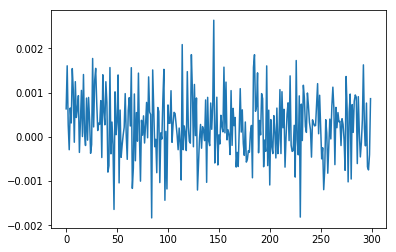

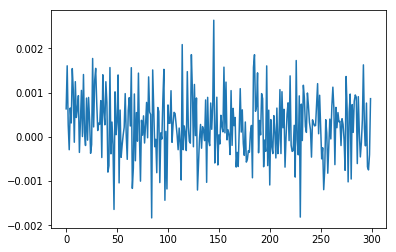

In [555]:
my_model = mrscmodel_20.model
T_0 = 20

##############################################
donor = pd.DataFrame(matrixFromSVD(my_model.skw, my_model.Ukw, my_model.Vkw))
target = pd.DataFrame(my_model.lastRowObservations, columns = [target_id]).T

mRSC_model = mRSC(donor, target, metrics, donor_ids, target_ids, [20], singvals)
mRSC_model.learn(target_id, T_0, method='pinv')

saeyoung_beta = mRSC_model.betas[0].values
jehangir_beta = my_model.weights

print("rmse between the two beta's", rmse(saeyoung_beta, jehangir_beta))

plt.plot(saeyoung_beta.flatten()[:300])
plt.show()

plt.plot(jehangir_beta[:300])
plt.show()


# SVD Wrapper

In [347]:
from tslib.src.algorithms.svdWrapper import SVDWrapper as SVD

In [355]:
newMatrix = my_model.matrix[:-1,:]
svdMod = SVD(newMatrix, method='numpy')

In [356]:
newMatrix.shape

(4738, 100)

In [352]:
(skw, sUkw, Vkw) = svdMod.reconstructMatrix(my_model.kSingularValues, returnMatrix=True)

In [354]:
skw.shape

(16,)

In [358]:
svdMod.reconstructMatrix(my_model.kSingularValues, returnMatrix=True).shape

(4738, 100)

### lr vs. pinv

In [252]:
#######################################################

# experiment prarams
train_pcts = [0.1, 0.25, 0.5, 0.75, 0.9]
freq = 15
T = int(12*60*4/freq + 1)
T_0s = [int(np.ceil(train_pct * T)) for train_pct in train_pcts]
singvals= 0
donor_ids = np.array(pd.read_pickle('../data/nba-hosoi/donor_ids.pkl'))
target_ids = np.array(pd.read_pickle('../data/nba-hosoi/target_ids.pkl'))
metrics = ['points','assists', 'rebounds', 'bs', 'fouls']

# import data
donor_home = getData("donor", "home", metrics, donor_ids)
donor_away = getData("donor", "away", metrics, donor_ids)

target_home = getData("target", "home", metrics, target_ids)
target_away = getData("target", "away", metrics, target_ids)

# """ lr """
# # construct model
# mRSC_home_lr = mRSC(donor_home, target_home, metrics, donor_ids, target_ids, T_0s, singvals)
# mRSC_home_lr.learn(target_id, T_0, method='lr')

# """ pinv """
# # construct model
# mRSC_home_pinv = mRSC(donor_home, target_home, metrics, donor_ids, target_ids, T_0s, singvals)
# mRSC_home_pinv.learn(target_id, T_0, method='pinv')

DataFrame size  (4738, 965) was created.
DataFrame size  (4738, 965) was created.
DataFrame size  (1179, 965) was created.
DataFrame size  (1179, 965) was created.


In [256]:
# check for different target id's
singvals = 16
j=5
T_0 = 20
j_s = np.random.randint(0,1000,5)

mRSC_home_lr = mRSC(donor_home, target_home, metrics, donor_ids, target_ids, T_0s, singvals)
mRSC_home_pinv = mRSC(donor_home, target_home, metrics, donor_ids, target_ids, T_0s, singvals)
    
for j in j_s:

    target_id = target_ids[j]
    mRSC_home_lr.learn(target_id, T_0, method='lr')
    mRSC_home_pinv.learn(target_id, T_0, method='pinv')

    print(target_id,": ", rmse(mRSC_home_pinv.betas[0].iloc[j,:].values, mRSC_home_lr.betas[0].iloc[j,:].values))

21700884 :  2.82007468785e-17
21700162 :  5.01686914227e-17
21700713 :  3.20116872691e-17
21700065 :  4.54681262509e-17
21700460 :  6.30157762298e-17


In [254]:
# check for different T_0's
singvals = 16
j=5

mRSC_home_lr = mRSC(donor_home, target_home, metrics, donor_ids, target_ids, T_0s, singvals)
mRSC_home_pinv = mRSC(donor_home, target_home, metrics, donor_ids, target_ids, T_0s, singvals)

for T_0 in T_0s:
    target_id = target_ids[j]
    mRSC_home_lr.learn(target_id, T_0, method='lr')
    mRSC_home_pinv.learn(target_id, T_0, method='pinv')

    print(T_0,": ", rmse(mRSC_home_pinv.betas[0].iloc[j,:].values, mRSC_home_lr.betas[0].iloc[j,:].values))

20 :  3.5393298914e-17
49 :  3.5393298914e-17
97 :  3.5393298914e-17
145 :  3.5393298914e-17
174 :  3.5393298914e-17


In [255]:
# check for different singvals
j=5
T_0 = 20
singvals_list = [1,2,4,8,16,32,50]
for singvals in singvals_list:
    target_id = target_ids[j]
    
    mRSC_home_lr = mRSC(donor_home, target_home, metrics, donor_ids, target_ids, T_0s, singvals)
    mRSC_home_pinv = mRSC(donor_home, target_home, metrics, donor_ids, target_ids, T_0s, singvals)

    mRSC_home_lr.learn(target_id, T_0, method='lr')
    mRSC_home_pinv.learn(target_id, T_0, method='pinv')

    print(singvals,": ", rmse(mRSC_home_pinv.betas[0].iloc[j,:].values, mRSC_home_lr.betas[0].iloc[j,:].values))

1 :  8.86746655056e-20
2 :  1.78637352413e-19
4 :  3.92879037394e-19
8 :  2.04465920828e-17
16 :  3.5393298914e-17
32 :  9.21933664439e-17
50 :  1.35817265248e-15
